In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
adata = sc.read_h5ad('../data/mtDNA_DSB_5k_clustered_LLM_anno.h5ad')

In [3]:
adata_MG = adata[adata.obs['cell_class'].str.contains('Micro')]

In [4]:
# dimensionality reduction
sc.pp.pca(adata_MG, n_comps=30)
sc.pp.neighbors(adata_MG, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_MG)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Clustering at resolution 0.3...
Done.


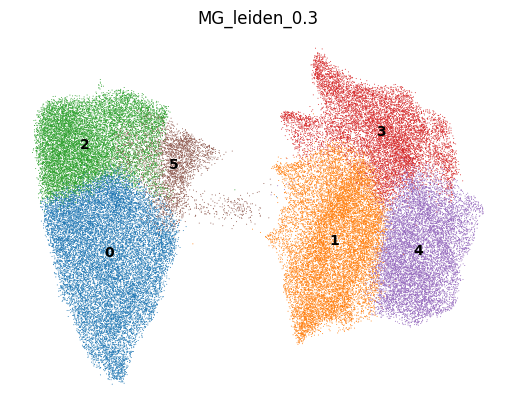

Clustering at resolution 0.5...
Done.


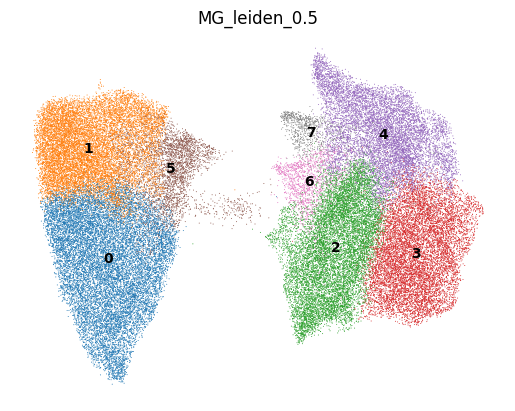

Clustering at resolution 0.8...
Done.


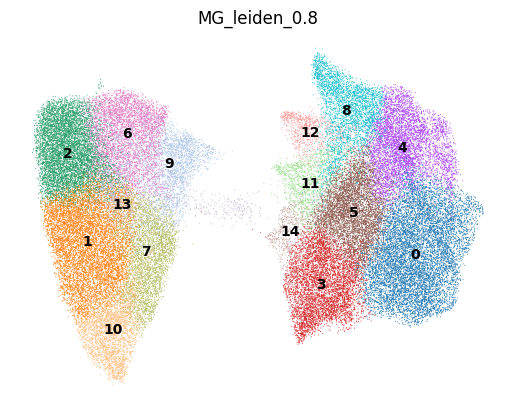

Clustering at resolution 1...
Done.


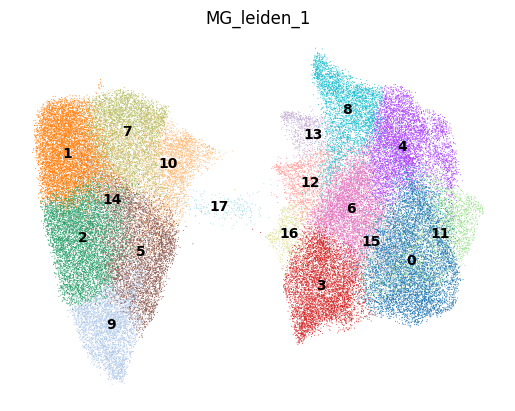

In [5]:
resolutions = [0.3, 0.5,0.8, 1]

for resolution in resolutions:
    key = f'MG_leiden_{resolution}'

    if key in adata_MG.obs.columns:
        print(f"Skipping {resolution}: {key} already exists.")
    else:
        print(f"Clustering at resolution {resolution}...")
        sc.tl.leiden(adata_MG, resolution=resolution, key_added=key)
        print("Done.")

    # plot UMAP
    sc.pl.umap(adata_MG, color=key, legend_loc='on data', frameon=False)

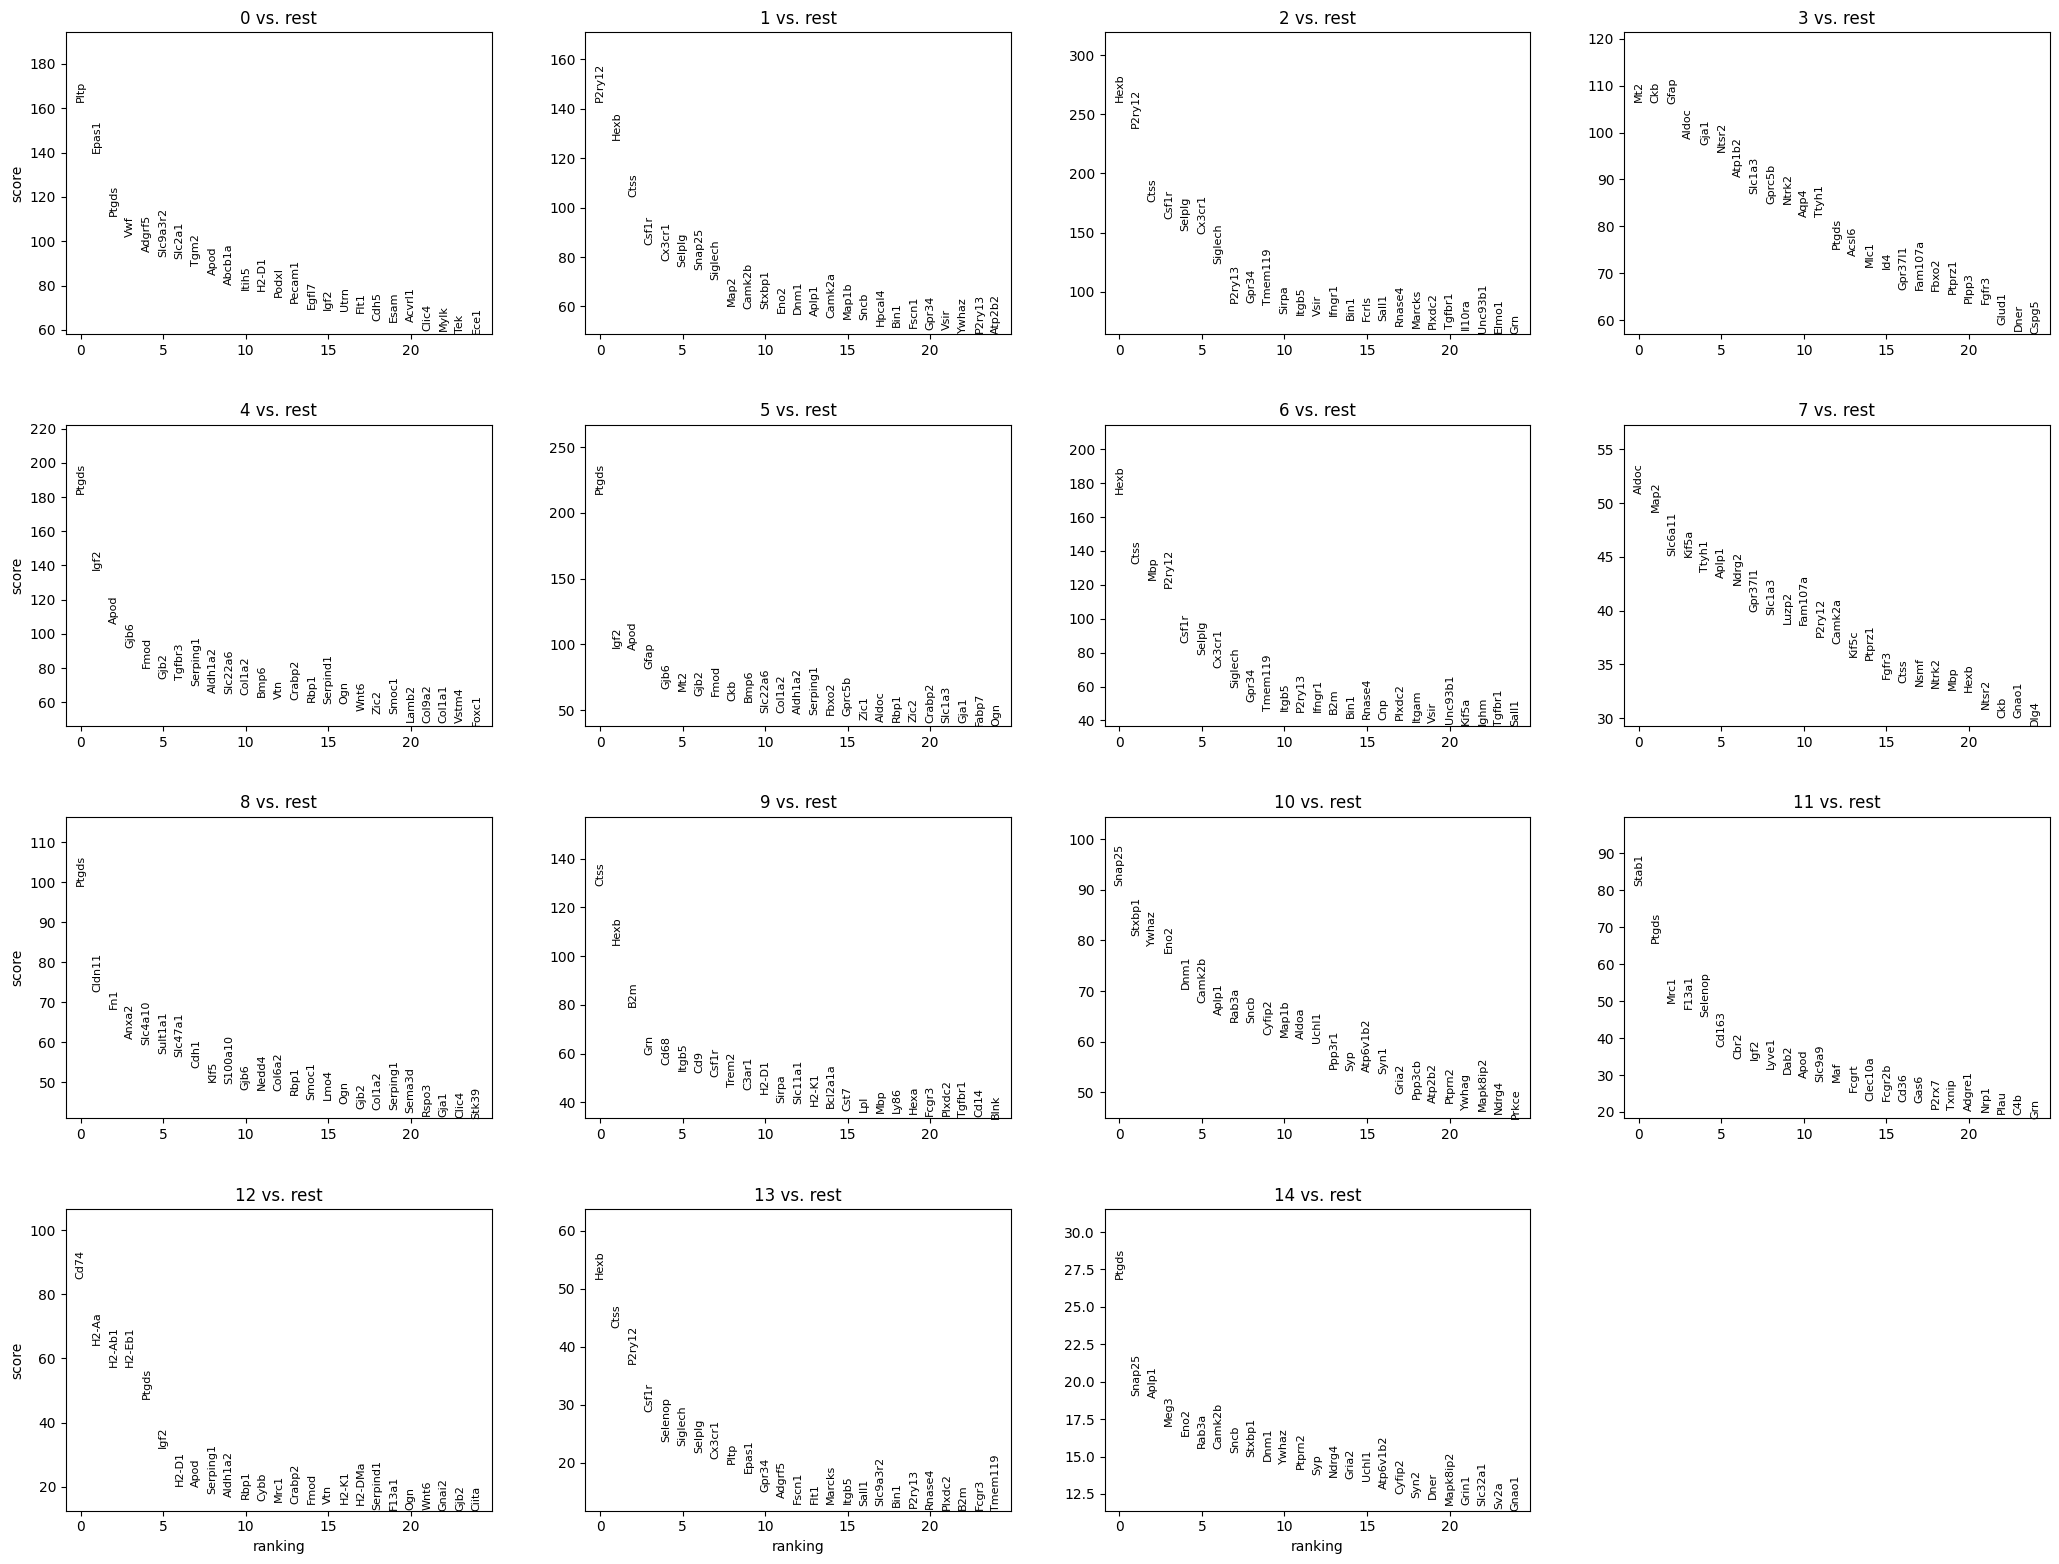

group   names      scores  logfoldchanges  pvals  pvals_adj
0     0    Pltp  162.854324        3.033851    0.0        0.0
1     0   Epas1  139.855591        2.807939    0.0        0.0
2     0   Ptgds  111.622528        1.572584    0.0        0.0
3     0     Vwf  101.794685        4.486909    0.0        0.0
4     0  Adgrf5   95.045578        3.520857    0.0        0.0

In [8]:
# --- Find marker genes per cluster ---
sc.tl.rank_genes_groups(adata_MG, groupby="MG_leiden_0.8", method="t-test")
sc.pl.rank_genes_groups(adata_MG, n_genes=25, sharey=False)

# get a tidy table of top markers
markers = sc.get.rank_genes_groups_df(adata_MG, group=None)
markers.head()

In [9]:
marker_genes = pd.DataFrame({
    group: adata_MG.uns['rank_genes_groups']['names'][group][:20]
    for group in adata_MG.uns['rank_genes_groups']['names'].dtype.names
})


In [10]:
for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()
    print(" ".join(genes))
    print(' ')

0
Pltp Epas1 Ptgds Vwf Adgrf5 Slc9a3r2 Slc2a1 Tgm2 Apod Abcb1a Itih5 H2-D1 Podxl Pecam1 Egfl7 Igf2 Utrn Flt1 Cdh5 Esam
 
1
P2ry12 Hexb Ctss Csf1r Cx3cr1 Selplg Snap25 Siglech Map2 Camk2b Stxbp1 Eno2 Dnm1 Aplp1 Camk2a Map1b Sncb Hpcal4 Bin1 Fscn1
 
2
Hexb P2ry12 Ctss Csf1r Selplg Cx3cr1 Siglech P2ry13 Gpr34 Tmem119 Sirpa Itgb5 Vsir Ifngr1 Bin1 Fcrls Sall1 Rnase4 Marcks Plxdc2
 
3
Mt2 Ckb Gfap Aldoc Gja1 Ntsr2 Atp1b2 Slc1a3 Gprc5b Ntrk2 Aqp4 Ttyh1 Ptgds Acsl6 Mlc1 Id4 Gpr37l1 Fam107a Fbxo2 Ptprz1
 
4
Ptgds Igf2 Apod Gjb6 Fmod Gjb2 Tgfbr3 Serping1 Aldh1a2 Slc22a6 Col1a2 Bmp6 Vtn Crabp2 Rbp1 Serpind1 Ogn Wnt6 Zic2 Smoc1
 
5
Ptgds Igf2 Apod Gfap Gjb6 Mt2 Gjb2 Fmod Ckb Bmp6 Slc22a6 Col1a2 Aldh1a2 Serping1 Fbxo2 Gprc5b Zic1 Aldoc Rbp1 Zic2
 
6
Hexb Ctss Mbp P2ry12 Csf1r Selplg Cx3cr1 Siglech Gpr34 Tmem119 Itgb5 P2ry13 Ifngr1 B2m Bin1 Rnase4 Cnp Plxdc2 Itgam Vsir
 
7
Aldoc Map2 Slc6a11 Kif5a Ttyh1 Aplp1 Ndrg2 Gpr37l1 Slc1a3 Luzp2 Fam107a P2ry12 Camk2a Kif5c Ptprz1 Fgfr3 Ctss Nsmf Ntrk2 Mbp
 
8

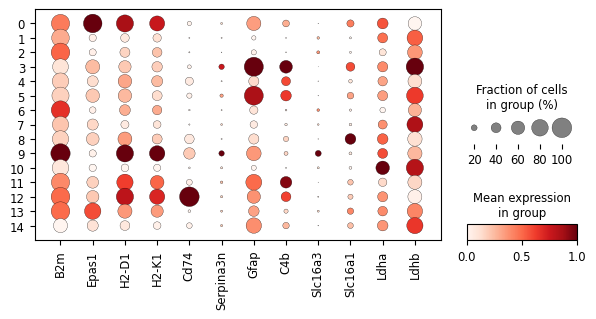

In [13]:
 sc.pl.dotplot(
        adata_MG,
        var_names=['B2m', 'Epas1', 'H2-D1', 'H2-K1', 'Cd74','Serpina3n','Gfap','C4b','Slc16a3','Slc16a1','Ldha','Ldhb'],
        groupby='MG_leiden_0.8',
        standard_scale="var",
        #dot_max=0.5,
        #dot_min=0.05,
        color_map="Reds",
        dendrogram=False,
        figsize=(7, 3),
        
    )

<Figure size 800x500 with 0 Axes>

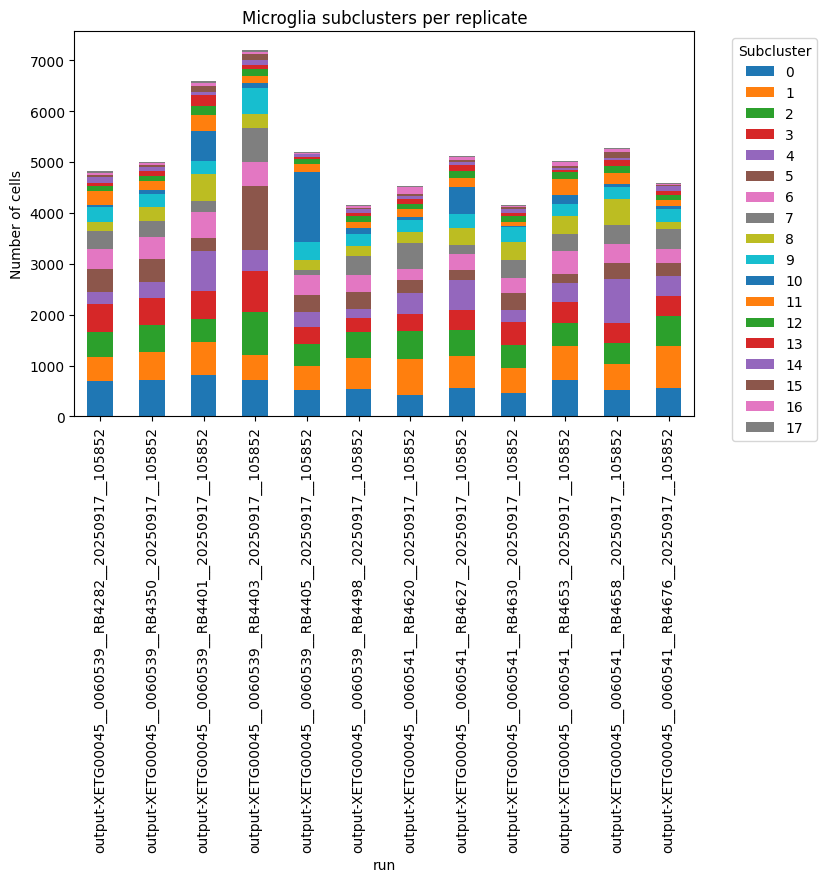

<Figure size 800x500 with 0 Axes>

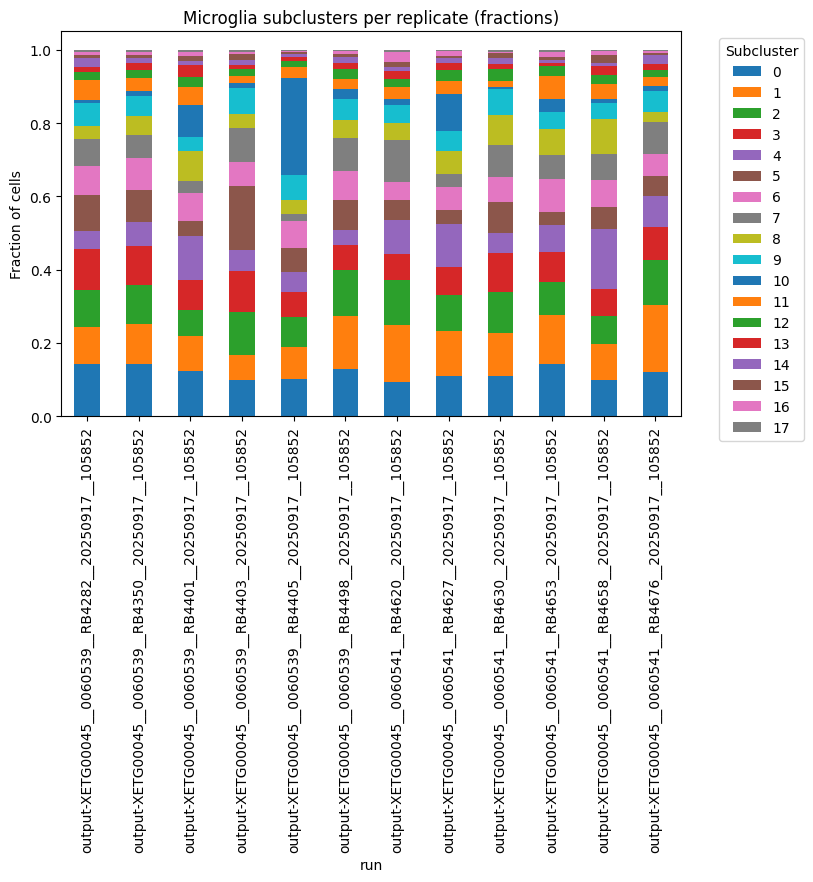

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# pick your cluster key (change if needed)
cluster_key = "MG_leiden_1"  

# count cells per replicate × cluster
ct = pd.crosstab(adata_MG.obs[cluster_key], adata_MG.obs["run"])

# plot counts
plt.figure(figsize=(8,5))
ct.T.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Number of cells")
plt.title("Microglia subclusters per replicate")
plt.legend(title="Subcluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# plot fractions
fractions = ct.div(ct.sum(axis=0), axis=1)

plt.figure(figsize=(8,5))
fractions.T.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Fraction of cells")
plt.title("Microglia subclusters per replicate (fractions)")
plt.legend(title="Subcluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

output-XETG00045__0060539__RB4282__20250917__105852


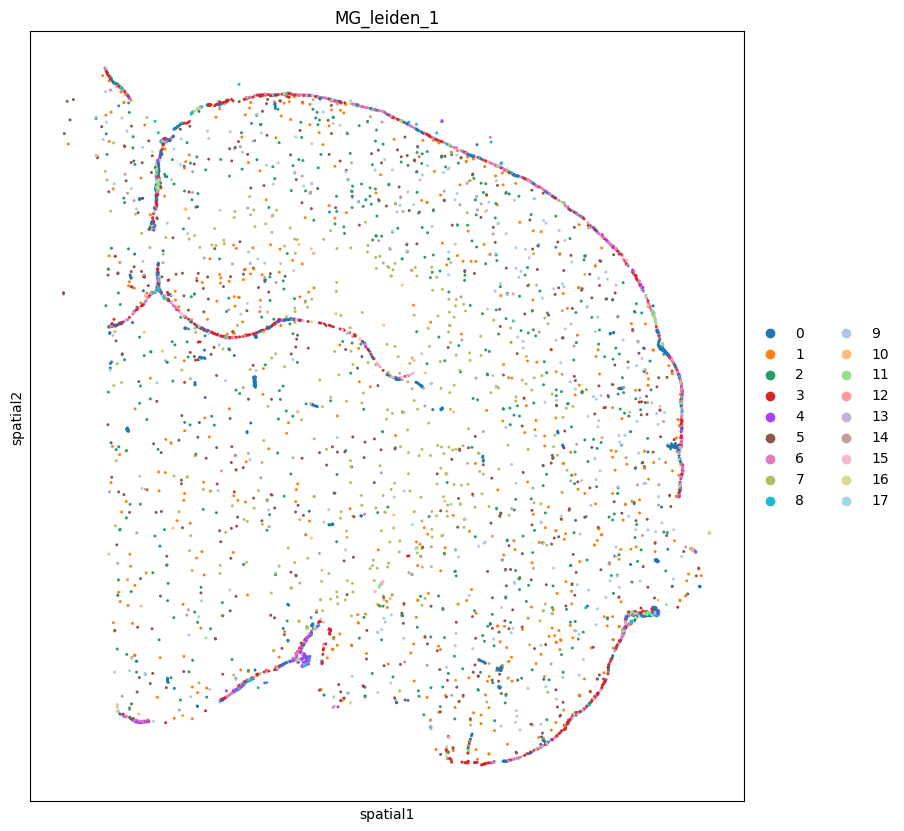

output-XETG00045__0060539__RB4350__20250917__105852


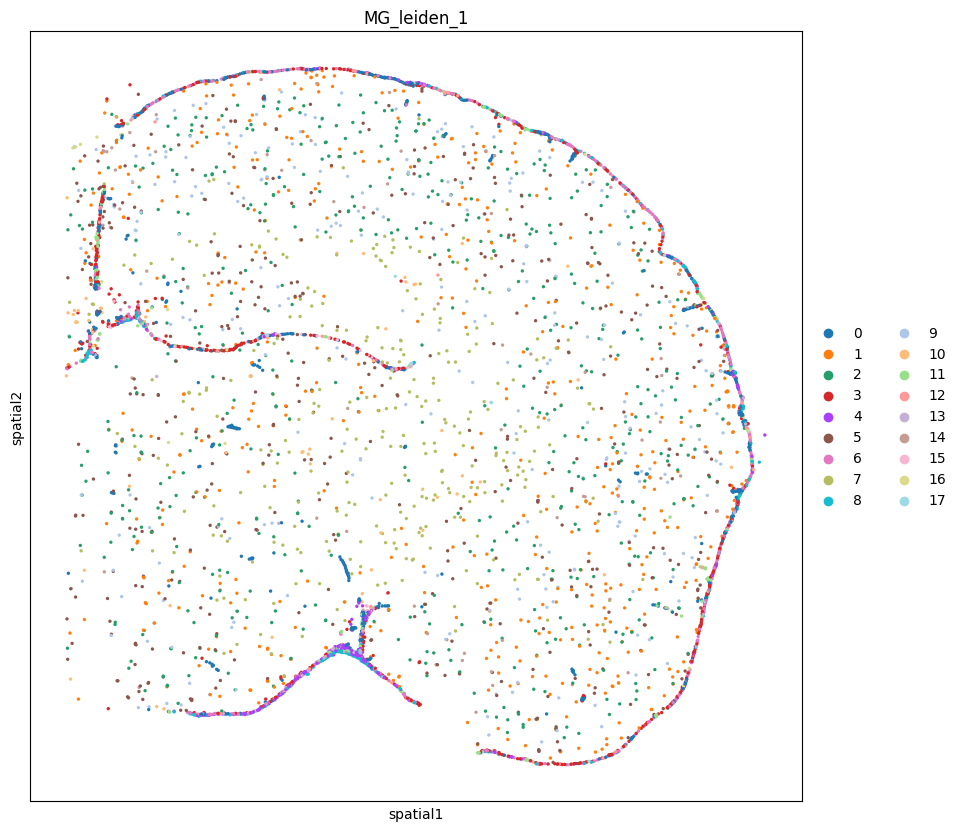

output-XETG00045__0060539__RB4401__20250917__105852


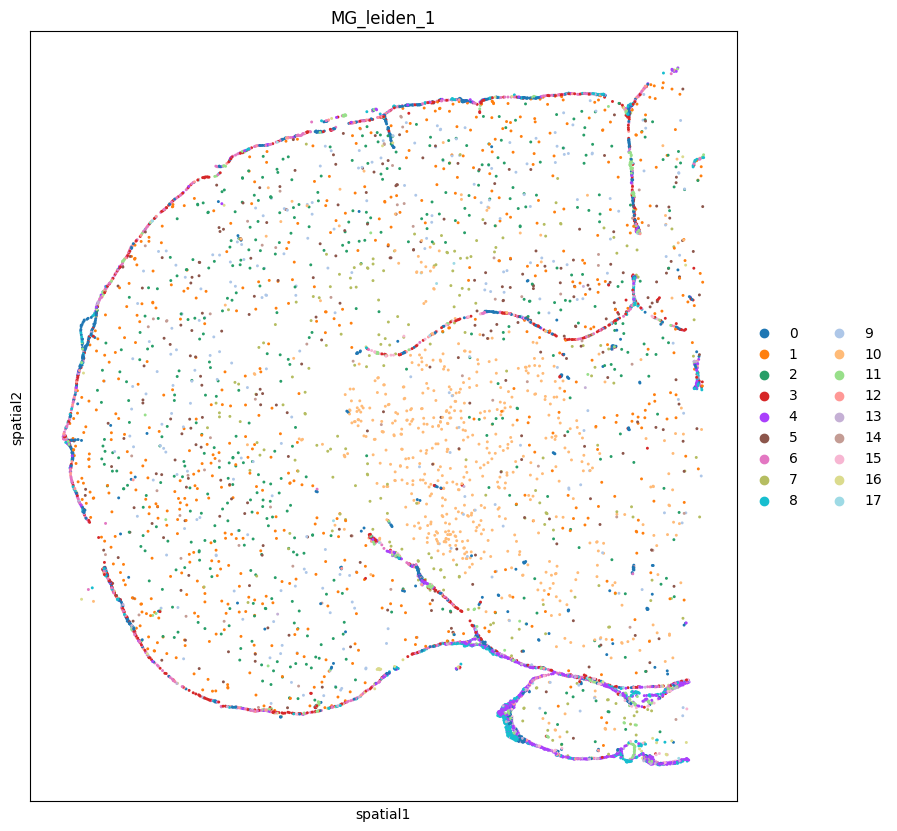

output-XETG00045__0060539__RB4403__20250917__105852


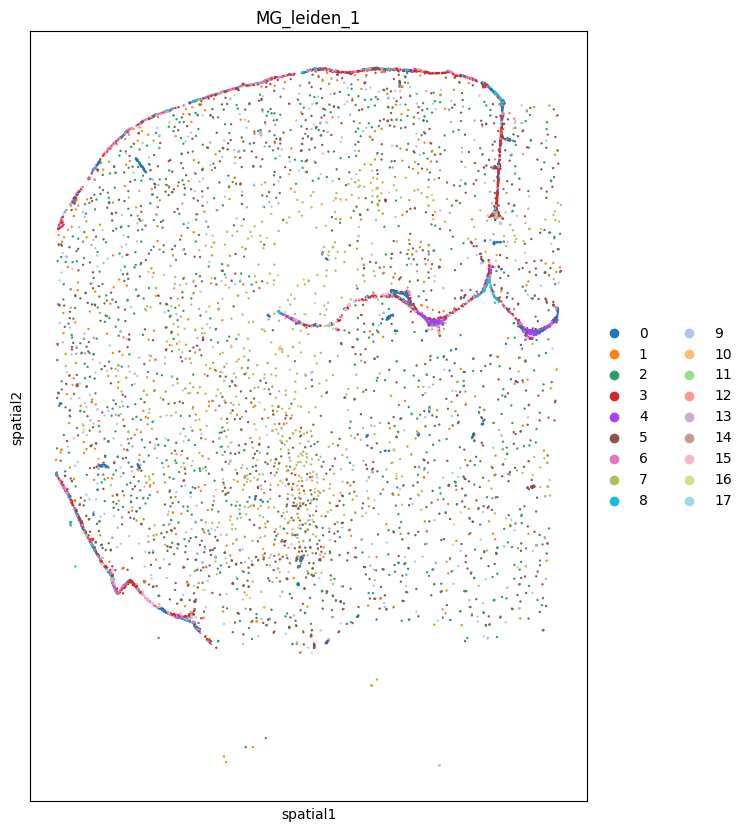

output-XETG00045__0060539__RB4405__20250917__105852


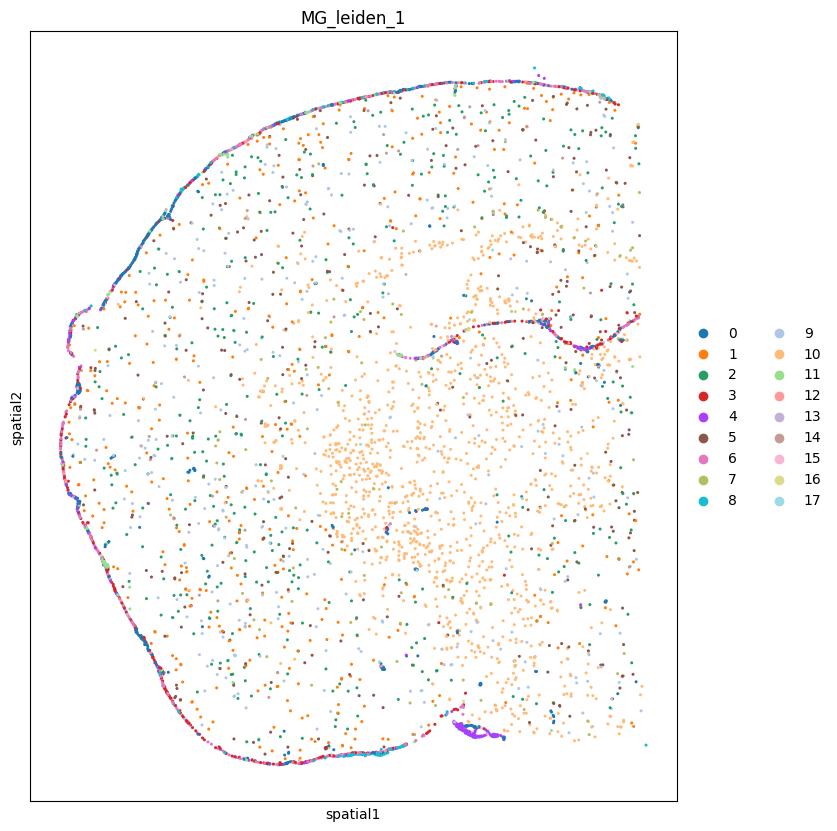

output-XETG00045__0060539__RB4498__20250917__105852


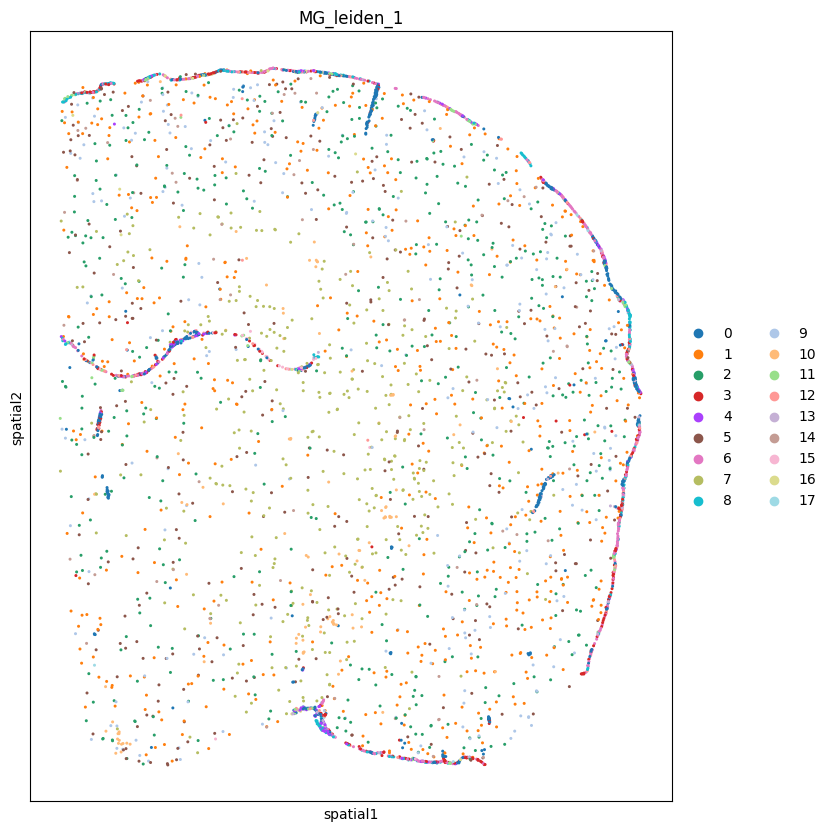

output-XETG00045__0060541__RB4620__20250917__105852


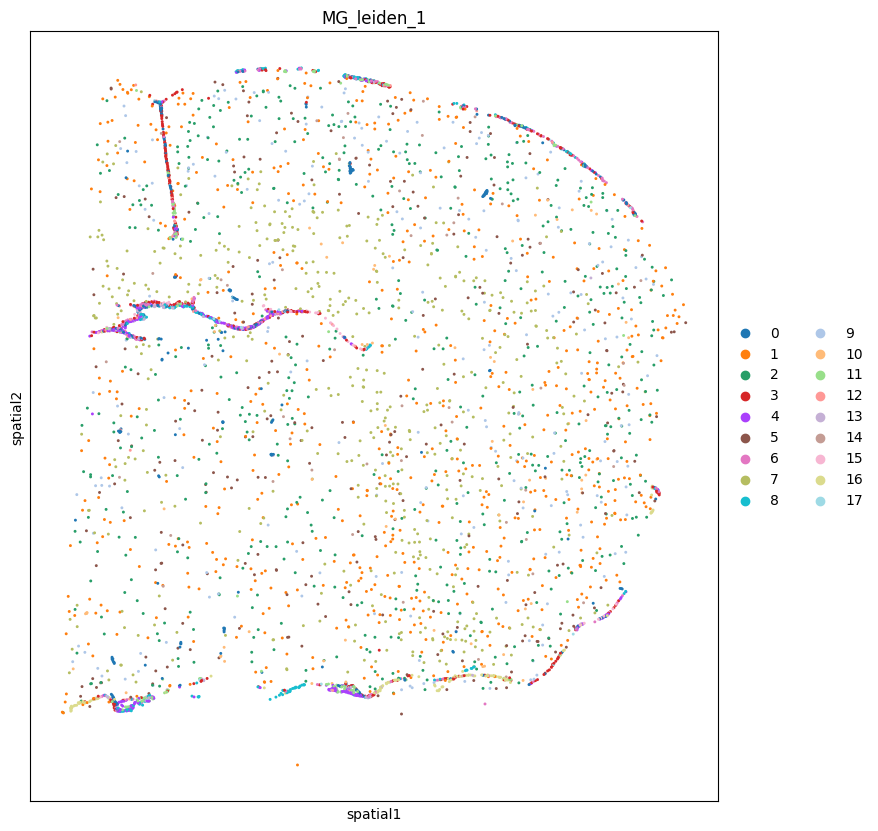

output-XETG00045__0060541__RB4627__20250917__105852


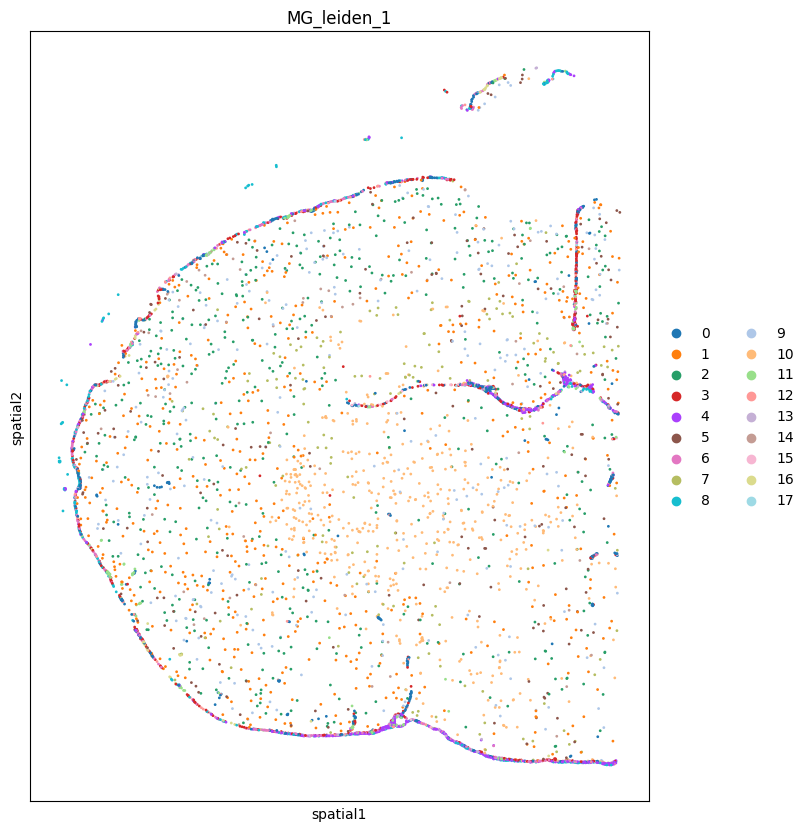

output-XETG00045__0060541__RB4630__20250917__105852


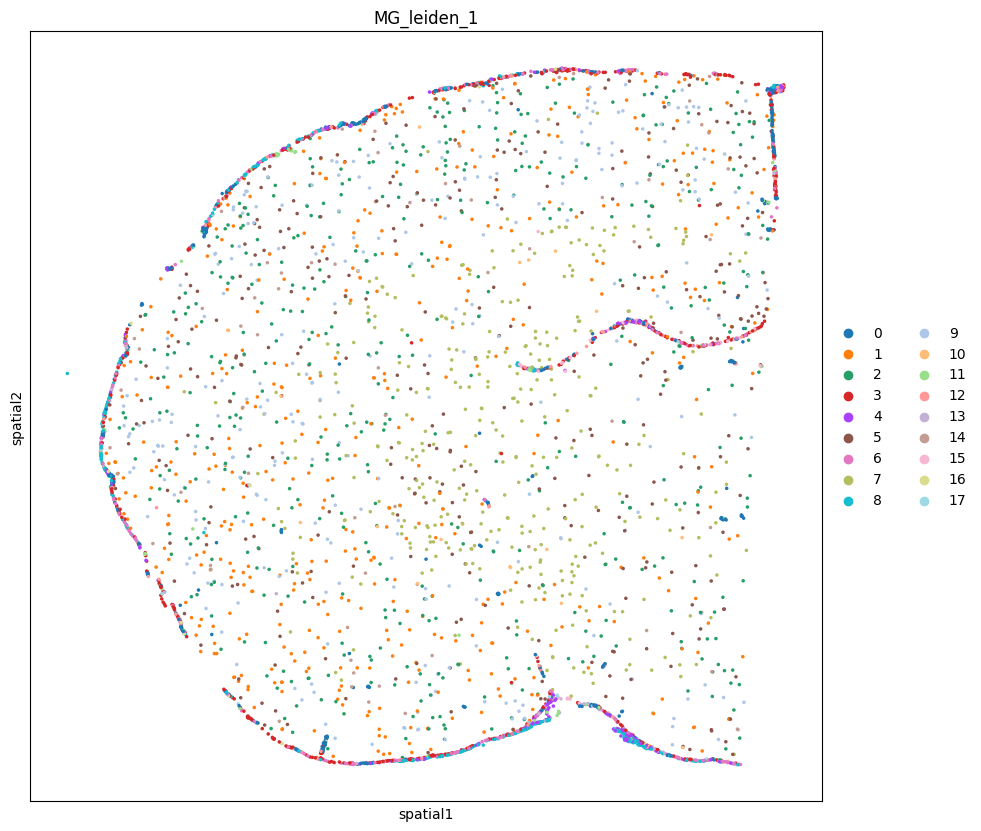

output-XETG00045__0060541__RB4653__20250917__105852


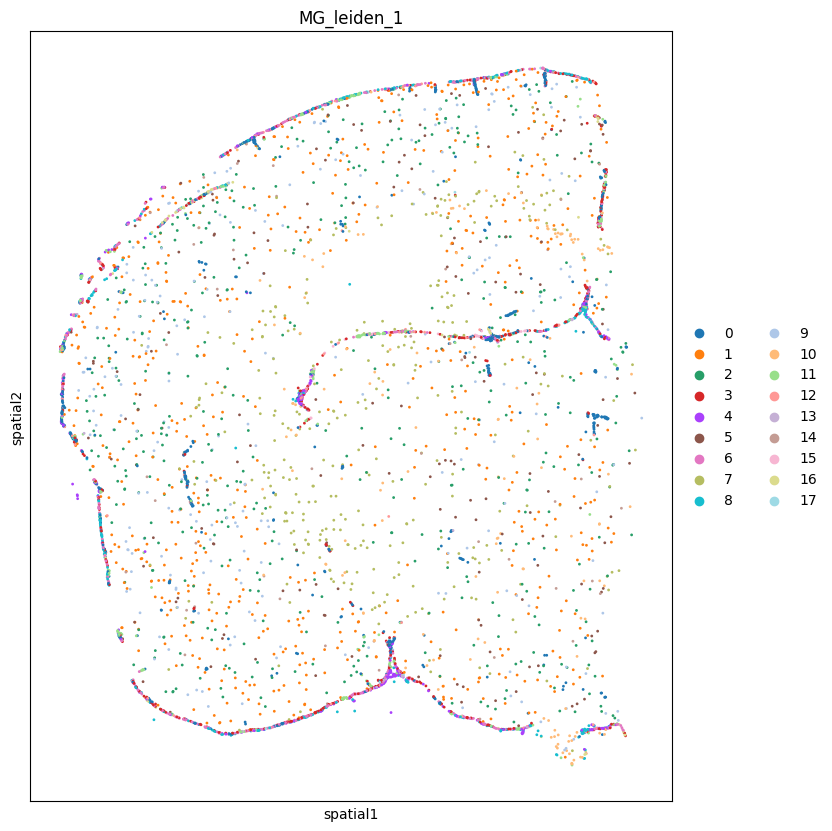

output-XETG00045__0060541__RB4658__20250917__105852


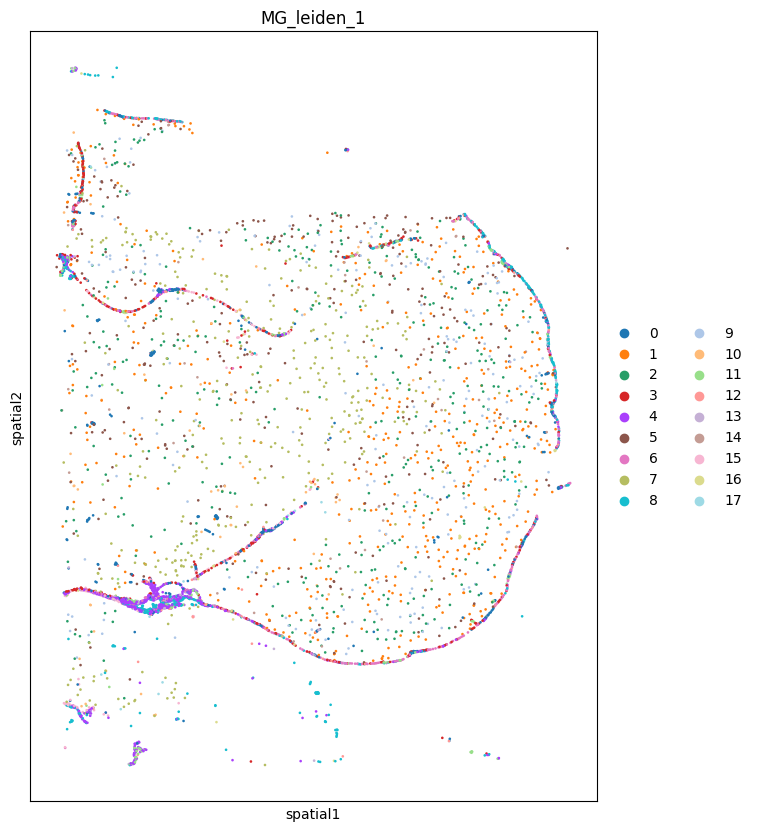

output-XETG00045__0060541__RB4676__20250917__105852


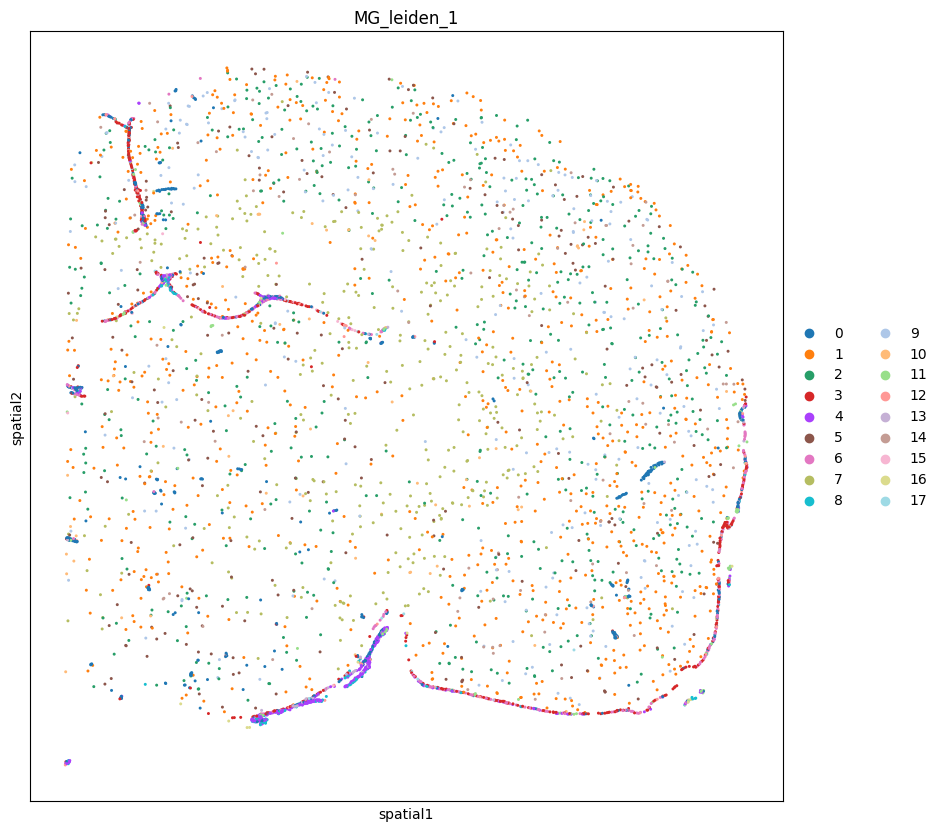

In [17]:
for run in adata_MG.obs['run'].unique():
    print(run)
    ad_int = adata_MG[adata_MG.obs['run'] == run]
    with plt.rc_context({'figure.figsize': (20, 10)}):
        sc.pl.spatial(ad_int, spot_size=25, color = 'MG_leiden_1')
    plt.show()
    